In [2]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import glob
import ipdb
import numpy as np

In [3]:
labels= pd.read_csv("kaggle-pneumonia/stage_2_train_labels.csv")

In [4]:
labels.head(10)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [5]:
labels=labels.drop_duplicates("patientId")
labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
10,008c19e8-a820-403a-930a-bc74a4053664,NaN,NaN,NaN,NaN,0
11,009482dc-3db5-48d4-8580-5c89c4f01334,NaN,NaN,NaN,NaN,0


In [6]:
root = "/home/aria/GNB/S21-S28/"
root_path = Path(root + "kaggle-pneumonia/stage_2_train_images")
save_path = Path(root + "proc/")

/home/aria/GNB/S21-S28/kaggle-pneumonia/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
/home/aria/GNB/S21-S28/kaggle-pneumonia/stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm
/home/aria/GNB/S21-S28/kaggle-pneumonia/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm
/home/aria/GNB/S21-S28/kaggle-pneumonia/stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm
/home/aria/GNB/S21-S28/kaggle-pneumonia/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm
/home/aria/GNB/S21-S28/kaggle-pneumonia/stage_2_train_images/00569f44-917d-4c86-a842-81832af98c30.dcm
/home/aria/GNB/S21-S28/kaggle-pneumonia/stage_2_train_images/006cec2e-6ce2-4549-bffa-eadfcd1e9970.dcm
/home/aria/GNB/S21-S28/kaggle-pneumonia/stage_2_train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm
/home/aria/GNB/S21-S28/kaggle-pneumonia/stage_2_train_images/008c19e8-a820-403a-930a-bc74a4053664.dcm


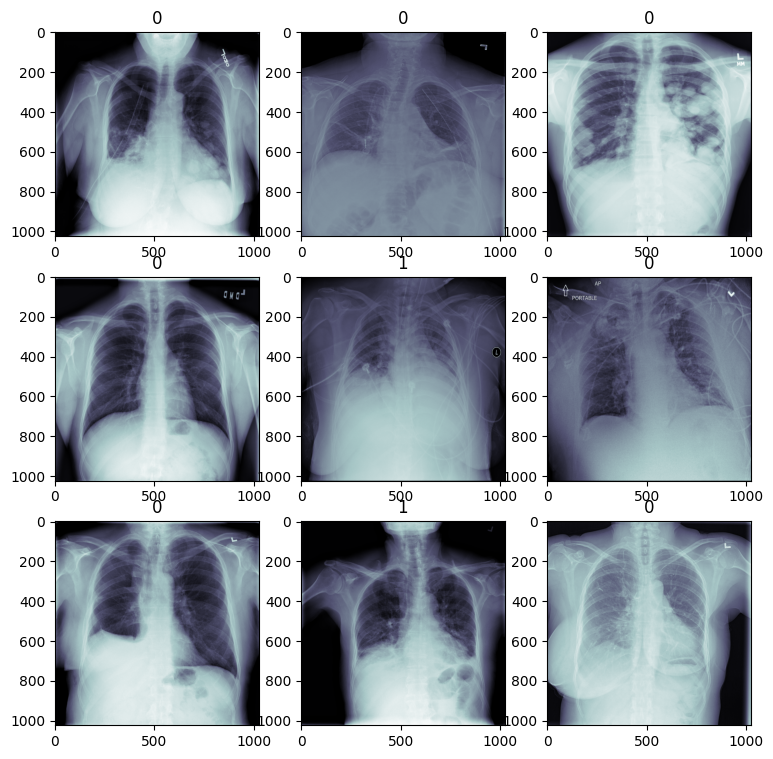

In [7]:
fig , ax = plt.subplots(3,3,figsize=(9,9))
counter = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[counter]
        dcm_path = root_path/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        print(dcm_path)
        dcm = pydicom.dcmread(dcm_path).pixel_array
        label = labels["Target"].iloc[counter]
        
        ax[i][j].imshow(dcm , cmap = 'bone')
        ax[i][j].set_title(label)
        
        counter +=1

In [8]:
lentrain=len(os.listdir(root + "/kaggle-pneumonia/stage_2_train_images/"))
lentrain

26684

In [9]:
round(lentrain * 0.9)

24016

In [10]:
lentest=len(os.listdir(root + "/kaggle-pneumonia/stage_2_test_images"))
lentest

3000

In [10]:
from tqdm import tqdm
sums=0
sums_sqr=0

x = round(lentrain * 0.9)
for counter , patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = root_path/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")

    if os.path.exists(dcm_path):
        dcm = pydicom.dcmread(dcm_path).pixel_array/255
        dcm_resized = cv2.resize(dcm , (224,224)).astype(np.float16)
        label = labels.Target.iloc[counter]
        train_val = "train" if counter < x else "val"

        my_save_path = save_path/train_val/str(label)
        my_save_path.mkdir(parents= True , exist_ok = True)
        np.save(my_save_path/patient_id, dcm_resized)
        
        normalizer = dcm_resized.shape[0] * dcm_resized.shape[1]
        if train_val == "train" :
            sums +=np.sum(dcm_resized)/ normalizer
            sums_sqr += (np.power(dcm_resized , 2).sum())/ normalizer
            
print(f"sums:{sums}")
print(f"sums_sqr:{sums_sqr}")

100%|██████████| 26684/26684 [03:38<00:00, 121.97it/s]

sums:2048.0
sums_sqr:1489.0


In [11]:
print(len(list((save_path / "train").rglob("*.npy"))))


24016


In [14]:
num_train_images = round(lentrain * 0.9)

mean = sums / num_train_images
std = np.sqrt(sums_sqr / num_train_images - mean**2)

print("Mean:", mean)
print("Std:", std)


Mean: 0.08527
Std: 0.2365


In [13]:
sums = 0
sums_sqr = 0

for files in glob.glob("proc/train/**/*.npy"):
    dcm = np.load(files)
    normalizer = dcm.shape[0]*dcm.shape[1]
    sums += np.sum(dcm) /  normalizer
    sums_sqr += (np.power(dcm , 2).sum()) / normalizer
    
print(f"sums:{sums}")
print(f"sums_sqr:{sums_sqr}")

sums:2048.0
sums_sqr:1517.0


In [15]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [17]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.08527 , 0.234 ), #transforms.Normalize(0.44 , 0.27 ),
    transforms.RandomAffine(degrees = (-5,+5),translate=(0, 0.05), scale=(0.9 , 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])


val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.08527] , [0.234] )#transforms.Normalize([0.44] , [0.27] )
])

In [18]:
train_dataset = torchvision.datasets.DatasetFolder(root + "proc/train/" ,loader = load_file, extensions = "npy" ,transform =  train_transforms)
val_dataset = torchvision.datasets.DatasetFolder(root + "proc/val/" ,loader = load_file, extensions = "npy" ,transform = val_transforms)

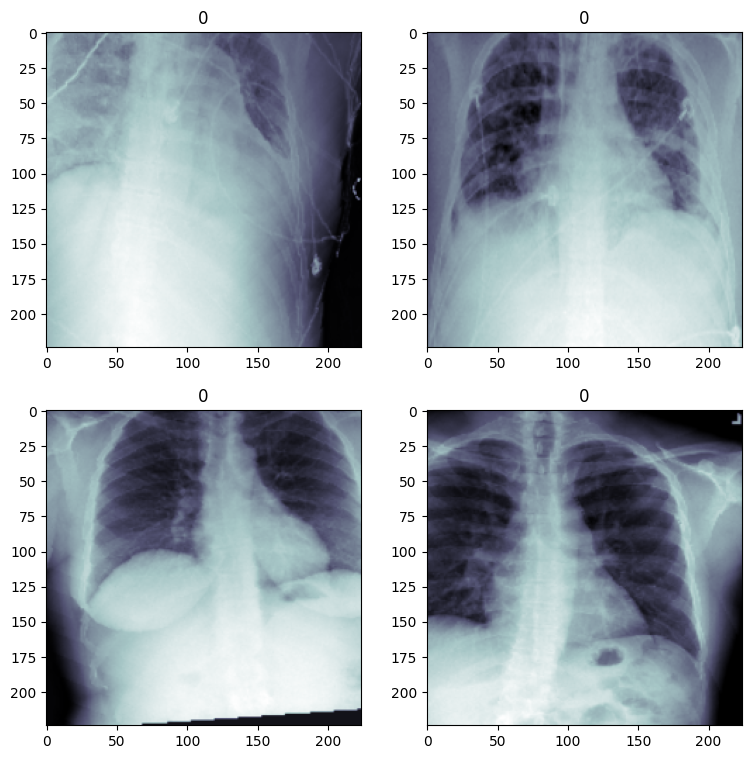

In [19]:
fig , ax = plt.subplots(2,2,figsize =(9,9))
for i in range(2):
    for j in range(2):
        ind = np.random.randint(0,20000)
        x_ray, label = train_dataset[ind]

        ax[i][j].imshow(x_ray[0], cmap="bone")
        ax[i][j].set_title(label)

In [20]:
batch_size = 64
num_workers = 4
train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=batch_size , num_workers=num_workers ,shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset , batch_size=batch_size , num_workers=num_workers ,shuffle = False)


In [21]:
model = torchvision.models.resnet18()

In [22]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:


import pytorch_lightning as pl
import torch
import torchvision
import torchmetrics

class PnuModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)


        self.log("train_loss", loss, on_step=True, on_epoch=False)
        self.train_acc(torch.sigmoid(pred), label.int())
        return loss

    def on_train_epoch_end(self):

        self.log("train_acc", self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.val_acc(torch.sigmoid(pred), label.int())
        return loss

    def on_validation_epoch_end(self):

        self.log("val_acc", self.val_acc.compute(), prog_bar=True)
        self.val_acc.reset()

    def configure_optimizers(self):
        return self.optimizer


In [24]:
model = PnuModel()
model

PnuModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",   
    save_top_k=10,
    mode="max"
)


In [27]:
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger("logs")
trainer = Trainer(logger=logger)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [28]:
from pathlib import Path
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    logger=TensorBoardLogger(save_dir=str(Path(root) / "logs")),
    callbacks=[checkpoint_callback],
    log_every_n_steps=1,
    max_epochs=35
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [58]:
trainer.fit(model ,train_loader , val_loader )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Epoch 34: 100%|██████████| 376/376 [00:47<00:00,  7.84it/s, v_num=1, val_acc=0.849, train_acc=0.857]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 376/376 [00:48<00:00,  7.81it/s, v_num=1, val_acc=0.849, train_acc=0.857]


In [29]:
model  =PnuModel.load_from_checkpoint("logs/lightning_logs/version_1/checkpoints/epoch=34-step=13160.ckpt")
model.eval()
model.to(device)

PnuModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [30]:
preds = []
labels = []


with torch.no_grad():
    for data , label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)

        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2668 [00:00<?, ?it/s]

In [ ]:
import torchmetrics


acc = torchmetrics.Accuracy(task="binary", threshold=0.5)(preds, labels)
precision = torchmetrics.Precision(task="binary", threshold=0.5)(preds, labels)
recall = torchmetrics.Recall(task="binary", threshold=0.5)(preds, labels)
CM = torchmetrics.ConfusionMatrix(task="binary", num_classes=2, threshold=0.5)(preds, labels)
CM_threshold = torchmetrics.ConfusionMatrix(task="binary", num_classes=2, threshold=0.25)(preds, labels)

print(f"acc : {acc}")
print(f"precision : {precision}")
print(f"recall : {recall}")
print(f"CM : {CM}")
print(f"CM_threshold : {CM_threshold}")


acc : 0.8485757112503052
precision : 0.7336448431015015
recall : 0.5198675394058228
CM : tensor([[1950,  114],
        [ 290,  314]])
CM_threshold : tensor([[1766,  298],
        [ 158,  446]])


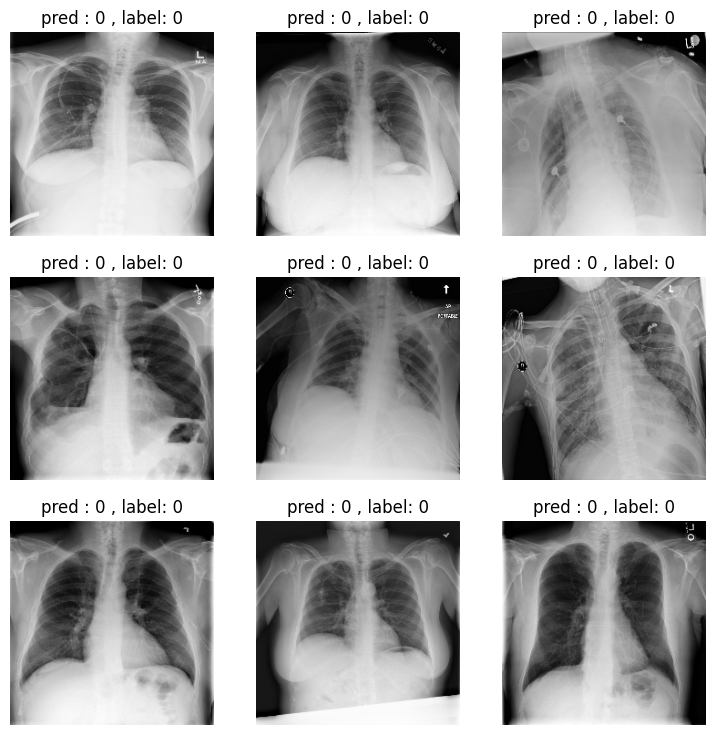

In [35]:
fig , ax = plt.subplots(3,3,figsize=(9,9))


for i in range(3):
    for j in range(3):
        random_idx = np.random.randint(0, len(preds))
        ax[i][j].imshow(val_dataset[random_idx][0][0] , cmap = "gray")
        ax[i][j].set_title(f"pred : {int(preds[random_idx] > 0.5)} , label: {labels[random_idx]}")
        ax[i][j].axis("off")